# Разведочный анализ данных

## Описание

Основная задача проекта – выявить ключевые темы обсуждений у 18 активных чатов и каналов выпускных сообществ Яндекс Практикума, определить, какие из них наиболее интересны аудитории, и на основе этого формировать информативные дайджесты для выпускников.

**Контекст**

- необходимо провести первичный анализ сообщений,

**Что нужно сделать?**

1. кто пишет часто
2. в какое время чаще всего пишут пользователи
3. сколько пишут сообщений сколько
4. анализ времени → пики активности, дни недели.
5. подумать, что можно еще посчитать полезного

**Результат:**

- код .py, .ipynb
- csv/xlsx файл со статистикой

## Библиотеки

In [26]:
import logging
import os
import warnings
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import mstats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import ast
from wordcloud import WordCloud
from collections import Counter

# Настройка параметров matplotlib
mpl.rcParams.update(mpl.rcParamsDefault)

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Игнорирование предупреждений
warnings.filterwarnings('ignore')

# Настройка стиля seaborn
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Включение отображения графиков в Jupyter Notebook
%matplotlib inline

## Загрузка датасетов

In [28]:
manage_alumin = pd.read_csv('.\datasets\MANAGEMENT ALUMNI PRACTICUM.csv')
data_practicum = pd.read_csv('.\datasets\Data Practicum Chat.csv')
marketing_chat = pd.read_csv('.\datasets\Marketing Practicum Chat.csv')


print('Загрузка MANAGEMENT ALUMNI PRACTICUM:', manage_alumin.shape, 'загрузка Data Practicum Chat:', 
data_practicum.shape, 'загрузка Marketing Practicum Chat:', marketing_chat.shape)

Загрузка MANAGEMENT ALUMNI PRACTICUM: (13, 18) загрузка Data Practicum Chat: (1007, 36) загрузка Marketing Practicum Chat: (3680, 31)


## 1. ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА


In [29]:
def preprocess_data(df, dataset_name):
    """Обработка данных перед анализом"""
    print(f"\nПредобработка {dataset_name}")
    
    # Удаление столбцов с >70% пропусков
    cols_to_drop = [col for col in df.columns if df[col].isnull().mean() > 0.7]
    df = df.drop(columns=cols_to_drop)
    print(f"Удалено столбцов: {len(cols_to_drop)}")
    
    # Преобразование даты
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df['hour'] = df['date'].dt.hour
        df['day_of_week'] = df['date'].dt.day_name()
        df['date_only'] = df['date'].dt.date
    
    # Обработка текста
    if 'text' in df.columns:
        try:
            df['text'] = df['text'].apply(ast.literal_eval)
            df['text_clean'] = df['text'].apply(lambda x: x[0]['text'] if x else None)
        except:
            df['text_clean'] = df['text']
    
    # Обработка реакций
    if 'reactions' in df.columns:
        try:
            df['reactions'] = df['reactions'].apply(ast.literal_eval)
            df['reactions_clean'] = df['reactions'].apply(
                lambda x: {item['emoji']: item['count'] for item in x} if x else None)
        except:
            pass
    
    return df

In [30]:
# Обрабатываем оба датасета
manage_alumin = preprocess_data(manage_alumin, "MANAGEMENT ALUMNI чат")
data_practicum = preprocess_data(data_practicum, "Data Practicum чат")
marketing_chat = preprocess_data(marketing_chat, 'marketing_chat чат')


Предобработка MANAGEMENT ALUMNI чат
Удалено столбцов: 0

Предобработка Data Practicum чат
Удалено столбцов: 22

Предобработка marketing_chat чат
Удалено столбцов: 19


## 2. ОСНОВНЫЕ МЕТРИКИ


In [32]:

def show_basic_metrics(df, dataset_name):
    """Вывод основных метрик"""
    print(f"\nОсновные метрики ({dataset_name}):")
    
    metrics = {
        'Всего сообщений': len(df),
        'Уникальных пользователей': len(df['from'].unique()),
        'Средняя длина сообщения': f"{df['text_clean'].str.len().mean():.1f} символов" if 'text_clean' in df.columns else 'N/A',
        'Период данных': f"{df['date'].min().date()} - {df['date'].max().date()}" if 'date' in df.columns else 'N/A'
    }
    
    for k, v in metrics.items():
        print(f"{k}: {v}")

show_basic_metrics(manage_alumin, "MANAGEMENT ALUMNI чат")
show_basic_metrics(data_practicum, "Data Practicum")
show_basic_metrics(marketing_chat, 'marketing_chat чат')


Основные метрики (MANAGEMENT ALUMNI чат):
Всего сообщений: 13
Уникальных пользователей: 1
Средняя длина сообщения: 39.8 символов
Период данных: 2025-02-01 - 2025-02-26

Основные метрики (Data Practicum):
Всего сообщений: 1007
Уникальных пользователей: 132
Средняя длина сообщения: 68.1 символов
Период данных: 2025-02-01 - 2025-02-27

Основные метрики (marketing_chat чат):
Всего сообщений: 3680
Уникальных пользователей: 85
Средняя длина сообщения: 78.4 символов
Период данных: 2025-02-01 - 2025-02-27


## 3. АКТИВНОСТЬ ПОЛЬЗОВАТЕЛЕЙ



Топ-20 пользователей (MANAGEMENT ALUMNI чат):
from
MANAGEMENT ALUMNI PRACTICUM    13
Name: count, dtype: int64


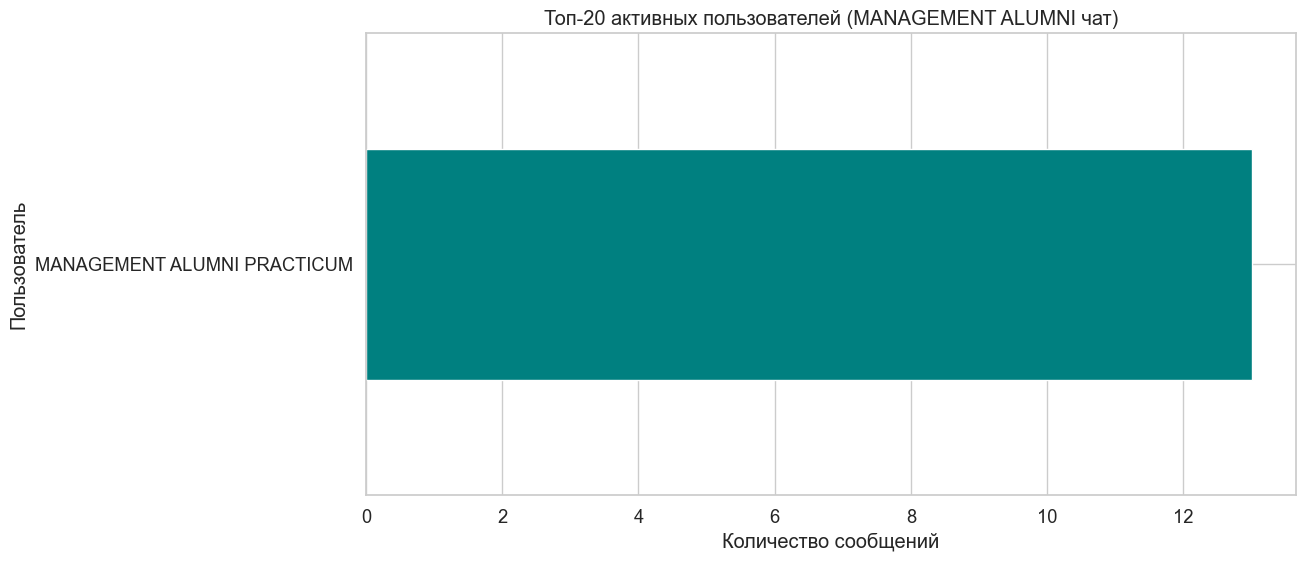


Топ-20 пользователей (Data Practicum):
from
Irina                            89
Andrey Novikov                   79
Мариян Умагалова                 78
Илья                             71
Sergey                           52
Arsen (არსენა) Хабибуллин        39
Ksenia                           34
Anna Glagoleva                   34
Ilya Plotnikov                   33
Катерина Ефремова [+2,5ч мск]    28
Aleksey Voronin                  28
Алексей Яцына                    26
Valerii Iliushin                 21
George                           20
Darya                            18
Дмитрий Лукьянов                 15
Vadim                            10
Руслан                            9
Valeratal                         9
Георгий Яковлев                   9
Name: count, dtype: int64


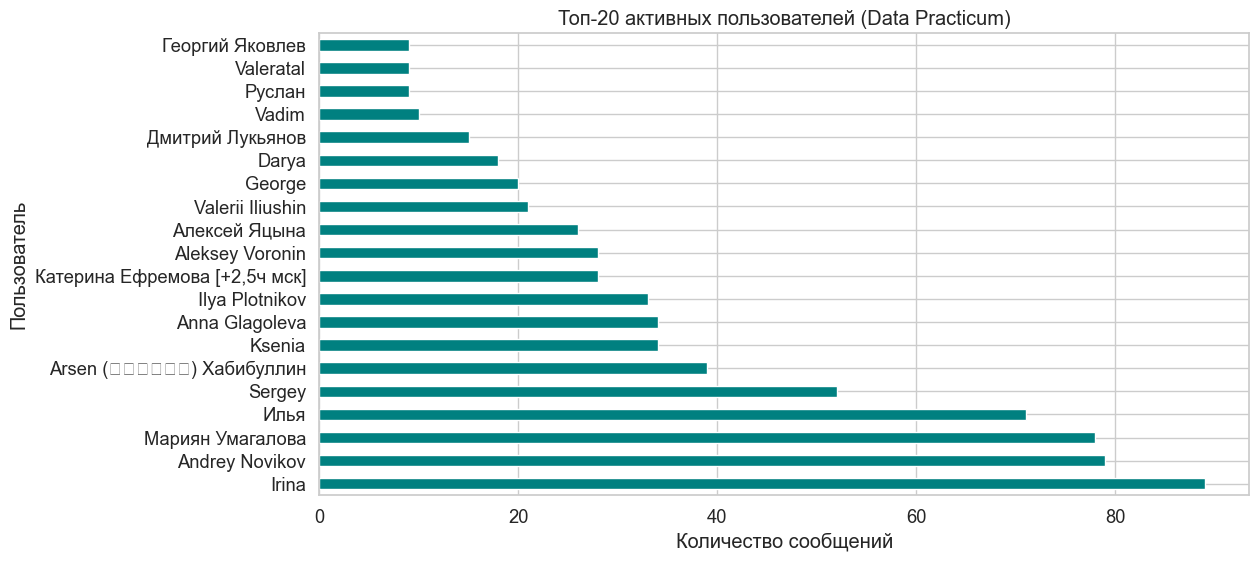

In [ ]:

def analyze_users(df, dataset_name, top_n=20):
    """Анализ активности пользователей"""
    print(f"\nТоп-{top_n} пользователей ({dataset_name}):")
    
    user_stats = df['from'].value_counts().head(top_n)
    print(user_stats)
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    user_stats.plot(kind='barh', color='teal')
    plt.title(f'Топ-{top_n} активных пользователей ({dataset_name})')
    plt.xlabel('Количество сообщений')
    plt.ylabel('Пользователь')
    plt.show()

analyze_users(manage_alumin, "MANAGEMENT ALUMNI чат")
analyze_users(data_practicum, "Data Practicum")
show_basic_metrics(marketing_chat, 'marketing_chat чат')

# 4. ВРЕМЕННАЯ АКТИВНОСТЬ



Временная активность (MANAGEMENT ALUMNI чат):


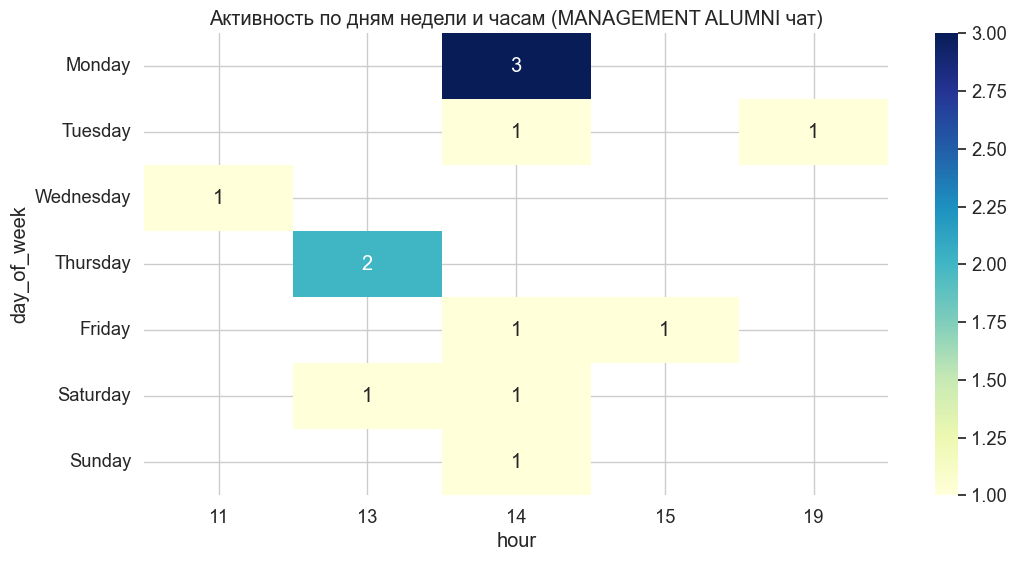

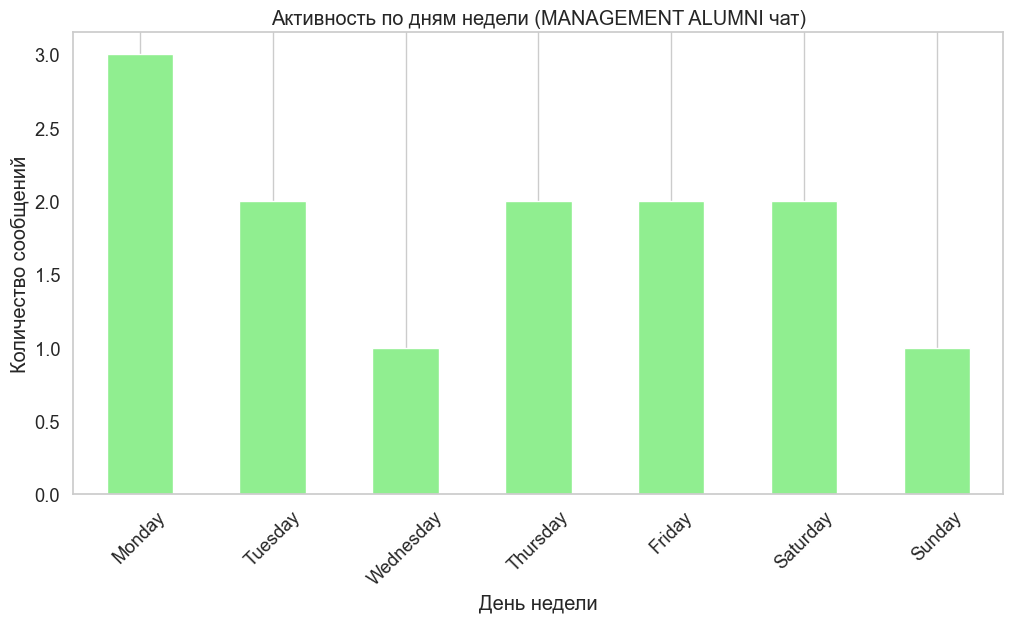

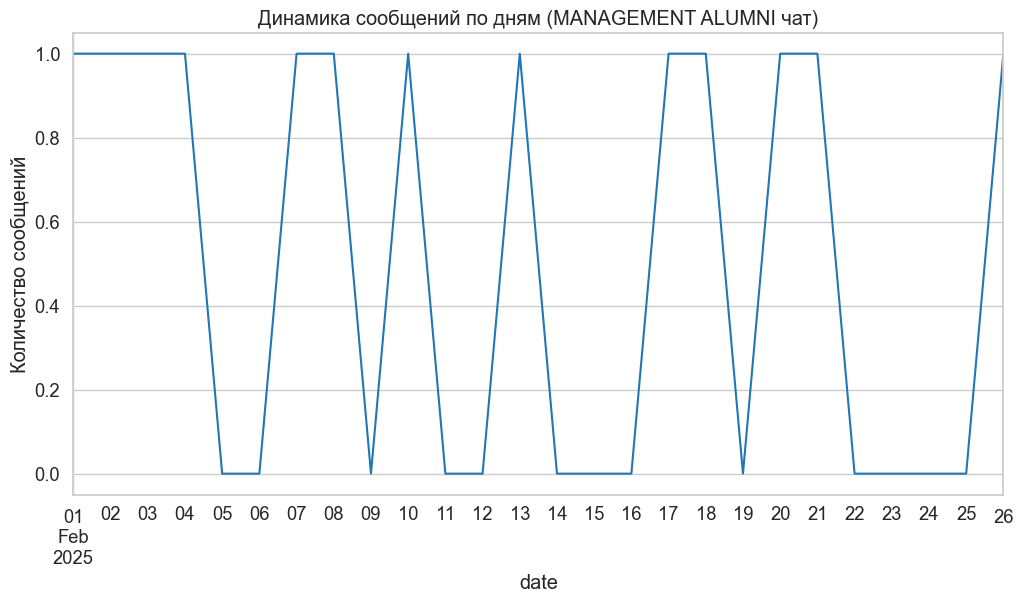


Временная активность (Data Practicum):


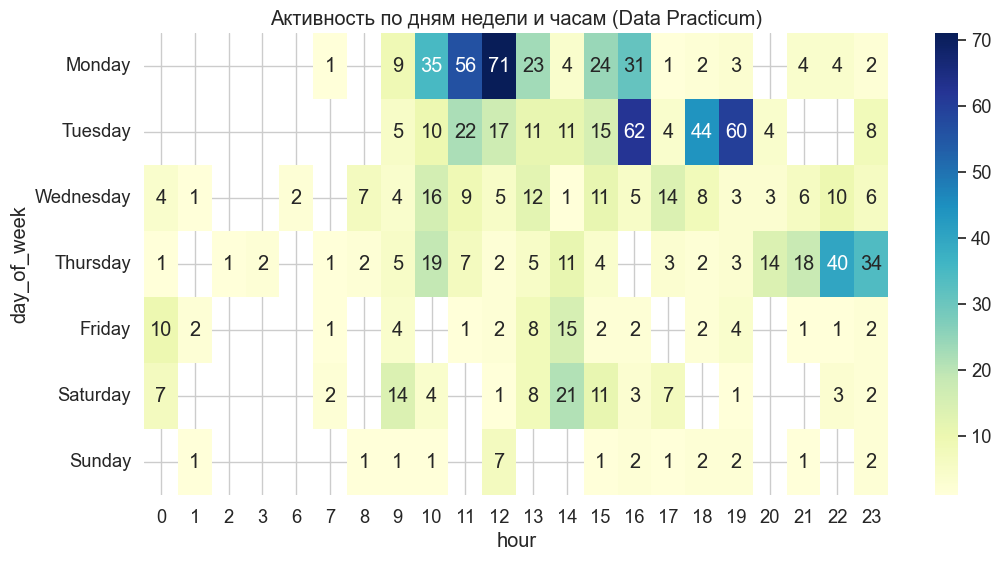

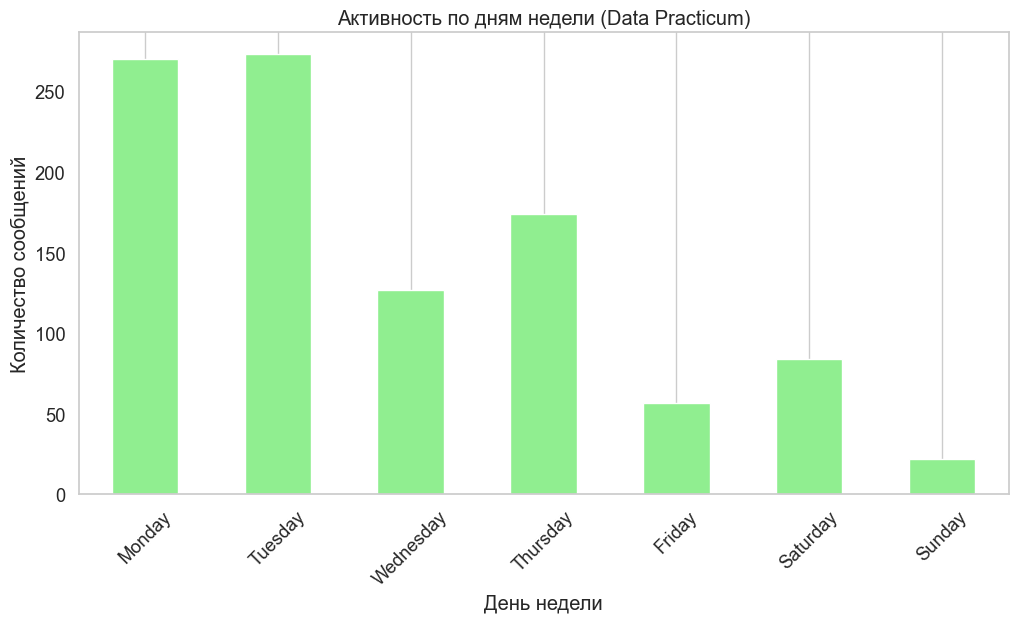

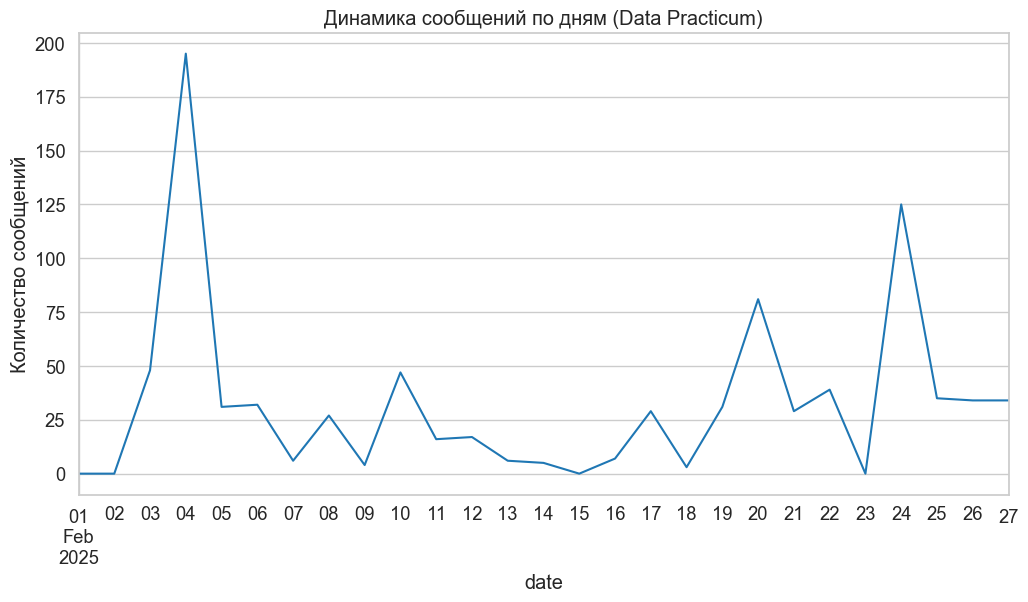


Временная активность (marketing_chat чат):


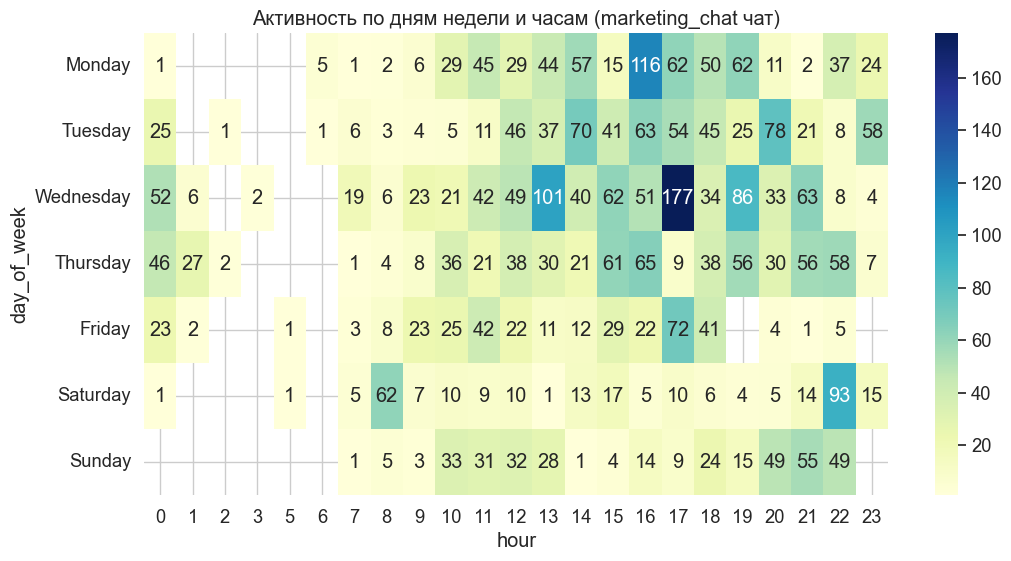

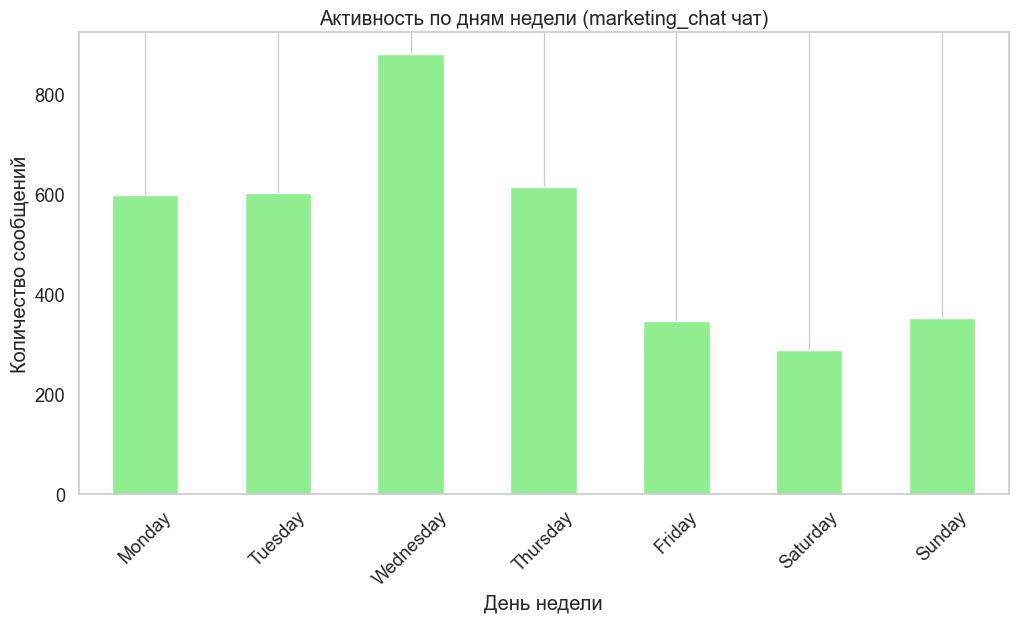

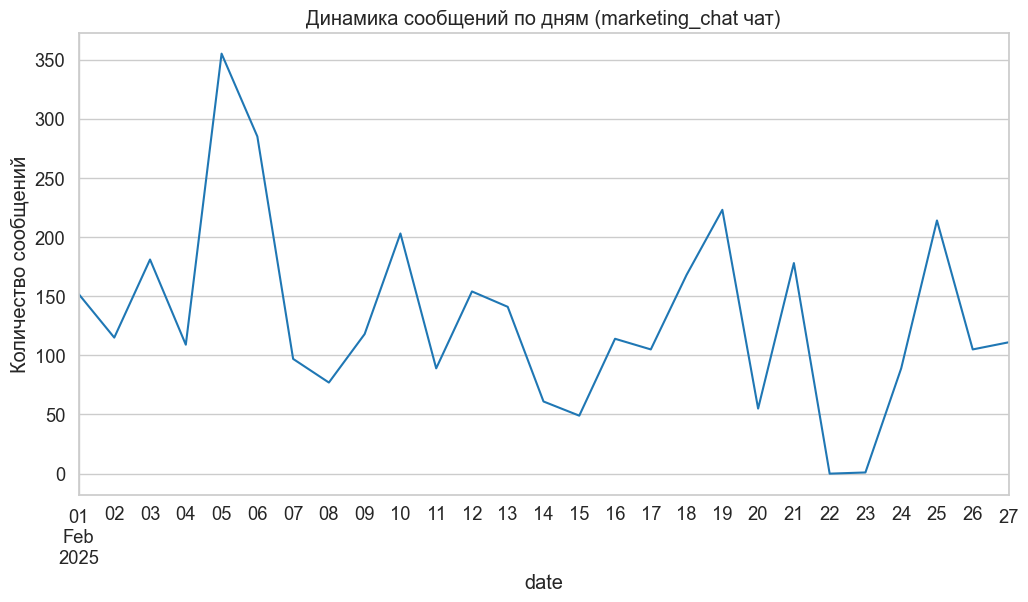

In [33]:

def analyze_time_activity(df, dataset_name):
    """Анализ временных паттернов"""
    print(f"\nВременная активность ({dataset_name}):")
    
    # Heatmap активности
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    plt.figure(figsize=(12, 6))
    heatmap_data = df.groupby(['day_of_week', 'hour']).size().unstack()
    heatmap_data = heatmap_data.reindex(days_order)
    sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="g")
    plt.title(f'Активность по дням недели и часам ({dataset_name})')
    plt.show()
    
    # Активность по дням недели
    plt.figure(figsize=(12, 6))
    df['day_of_week'].value_counts().reindex(days_order).plot(kind='bar', color='lightgreen')
    plt.title(f'Активность по дням недели ({dataset_name})')
    plt.xlabel('День недели')
    plt.ylabel('Количество сообщений')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()
    
    # Динамика по дням
    plt.figure(figsize=(12, 6))
    df.set_index('date')['text_clean'].resample('D').count().plot()
    plt.title(f'Динамика сообщений по дням ({dataset_name})')
    plt.ylabel('Количество сообщений')
    plt.grid(True)
    plt.show()

analyze_time_activity(manage_alumin, "MANAGEMENT ALUMNI чат")
analyze_time_activity(data_practicum, "Data Practicum")
analyze_time_activity(marketing_chat, 'marketing_chat чат')

## 5. АНАЛИЗ ТЕКСТА



Анализ текста (MANAGEMENT ALUMNI чат):


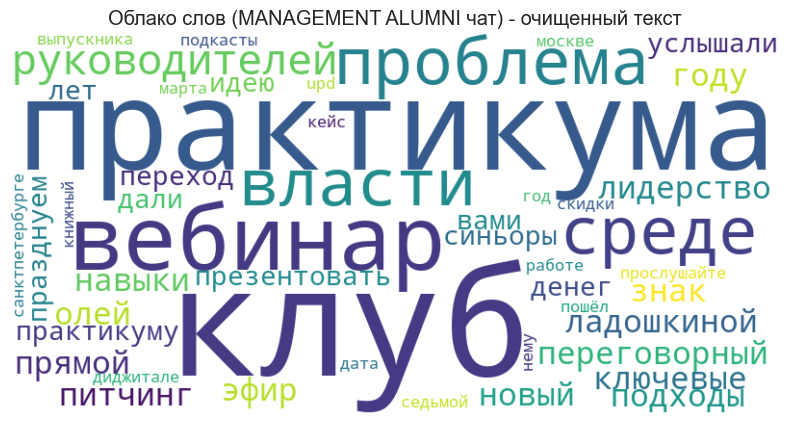

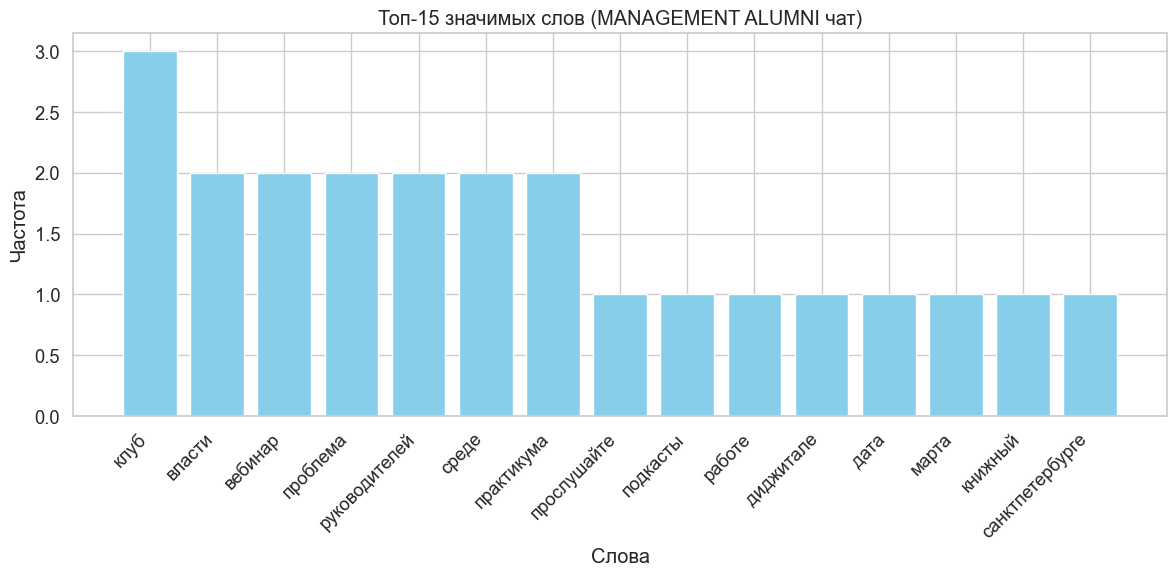


Анализ текста (Data Practicum):


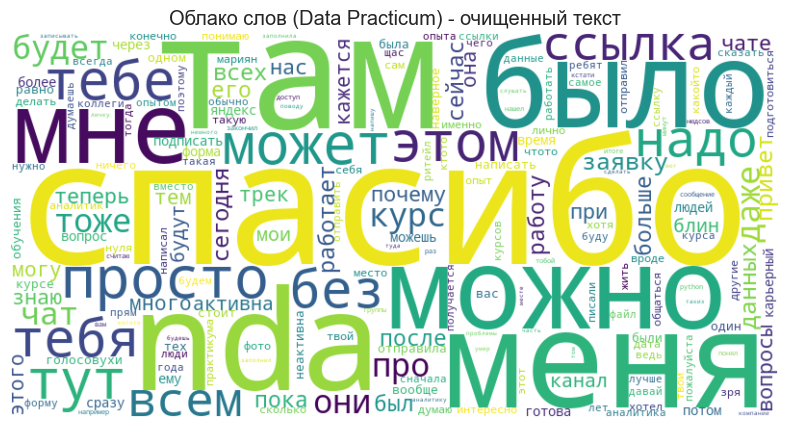

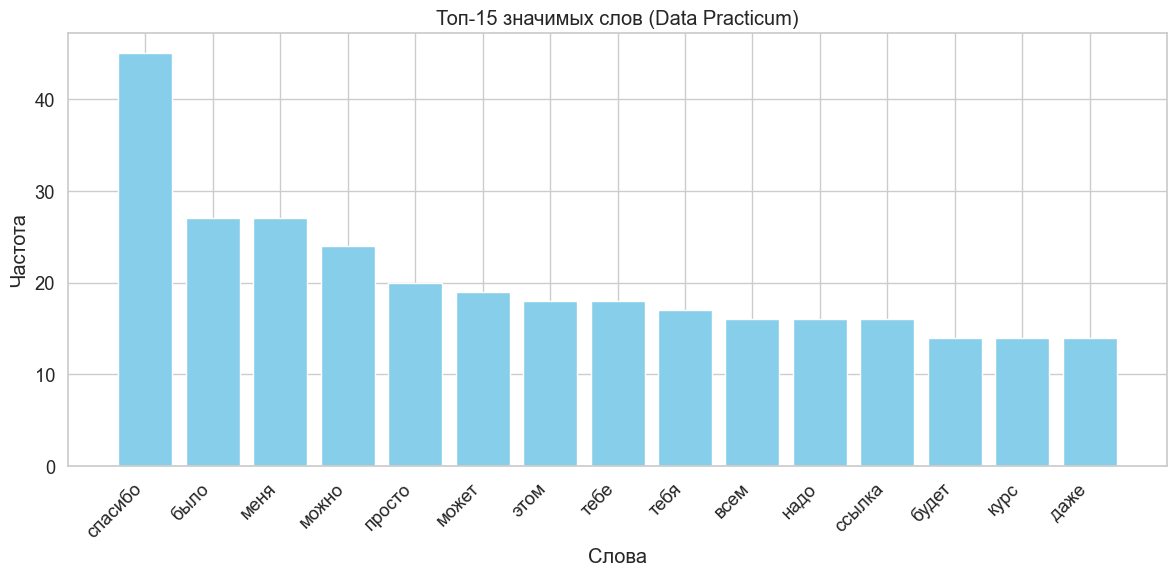


Анализ текста (marketing_chat чат):


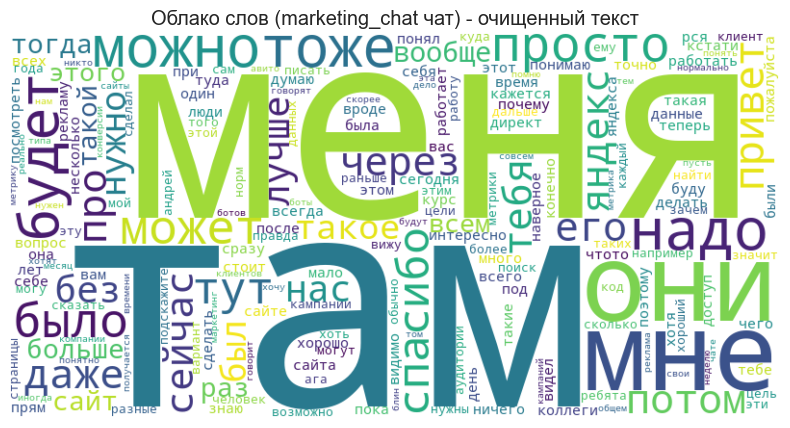

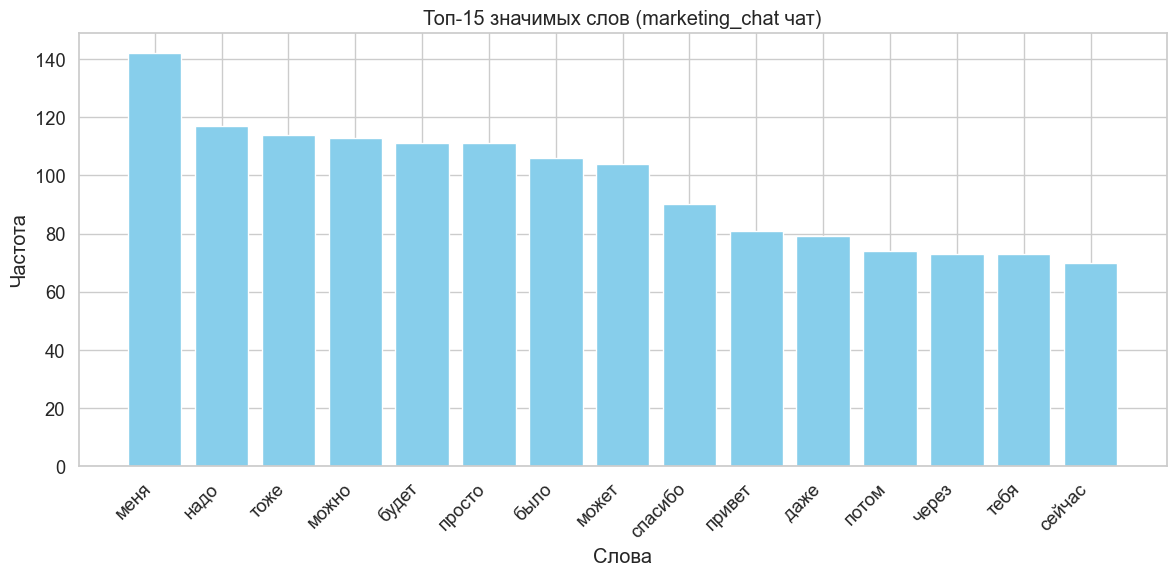

In [34]:
def clean_text(text):
    """Улучшенная очистка текста от технических артефактов и мусора"""
    if not isinstance(text, str) or text.lower() in ['nan', 'none', 'null']:
        return ''
    
    # Удаляем фигурные скобки и их содержимое
    text = re.sub(r'\{.*?\}', '', text)
    # Удаляем квадратные скобки и их содержимое
    text = re.sub(r'\[.*?\]', '', text)
    # Удаляем HTML-теги
    text = re.sub(r'<.*?>', '', text)
    # Удаляем специальные символы (кроме букв, цифр и пробелов)
    text = re.sub(r'[^\w\s]', '', text)
    # Удаляем одиночные символы и цифры
    text = ' '.join([word for word in text.split() 
                    if len(word) > 2 and not word.isdigit()])
    # Приводим к нижнему регистру
    text = text.lower()
    return text

def analyze_text(df, dataset_name):
    """Анализ текстовых данных с улучшенной очисткой"""
    print(f"\nАнализ текста ({dataset_name}):")
    
    if 'text_clean' not in df.columns or df['text_clean'].isna().all():
        print("Нет данных для анализа текста")
        return
    
    # Дополнительная очистка текста
    df['text_processed'] = df['text_clean'].apply(clean_text)
    
    # Облако слов
    text = ' '.join([str(t) for t in df['text_processed'] if t and str(t) != 'nan'])
    if not text.strip():
        print("Нет текста для визуализации")
        return
    
    # Расширенный список стоп-слов
    custom_stopwords = {
        'text', 'type', 'none', 'nan', 'null', 'http', 'https', 'com', 'www',
        'n', 'amp', 'quot', 'rt', 'gt', 'lt', 'co', 'да', 'нет', 'это', 'что',
        'как', 'для', 'или', 'если', 'чтобы', 'так', 'вот', 'быть', 'есть',
        'только', 'уже', 'ещё', 'еще', 'все', 'всё', 'который', 'которые',
        'когда', 'где', 'кто', 'чем', 'потому', 'что', 'очень', 'свой', 'наш',
        'ваш', 'их', 'им', 'него', 'нее', 'них', 'ними', 'которых', 'которым',
        'которыми', 'какой', 'какая', 'какое', 'какие', 'каким', 'какими',
        'каков', 'какова', 'каково', 'каковы'
    }
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        stopwords=custom_stopwords,
        collocations=False
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Облако слов ({dataset_name}) - очищенный текст')
    plt.axis('off')
    plt.show()
    
    # Топ слов (с исключением служебных слов)
    clean_texts = df['text_processed'].dropna().astype(str)
    all_words = [
        word for text in clean_texts 
        for word in text.split() 
        if (len(word) > 3 and 
            word not in custom_stopwords and
            not word.isdigit())
    ]
    
    if not all_words:
        print("Не удалось выделить значимые слова")
        return
    
    word_counts = Counter(all_words)
    word_counts_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
    word_counts_df = word_counts_df.sort_values('frequency', ascending=False)
    
    plt.figure(figsize=(12, 6))
    top_words = word_counts_df.head(15)
    plt.bar(top_words['word'], top_words['frequency'], color='skyblue')
    plt.title(f'Топ-15 значимых слов ({dataset_name})')
    plt.xlabel('Слова')
    plt.ylabel('Частота')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Анализ данных
analyze_text(manage_alumin, "MANAGEMENT ALUMNI чат")
analyze_text(data_practicum, "Data Practicum")
analyze_text(marketing_chat, 'marketing_chat чат')

## 6. ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ



Дополнительный анализ (MANAGEMENT ALUMNI чат):


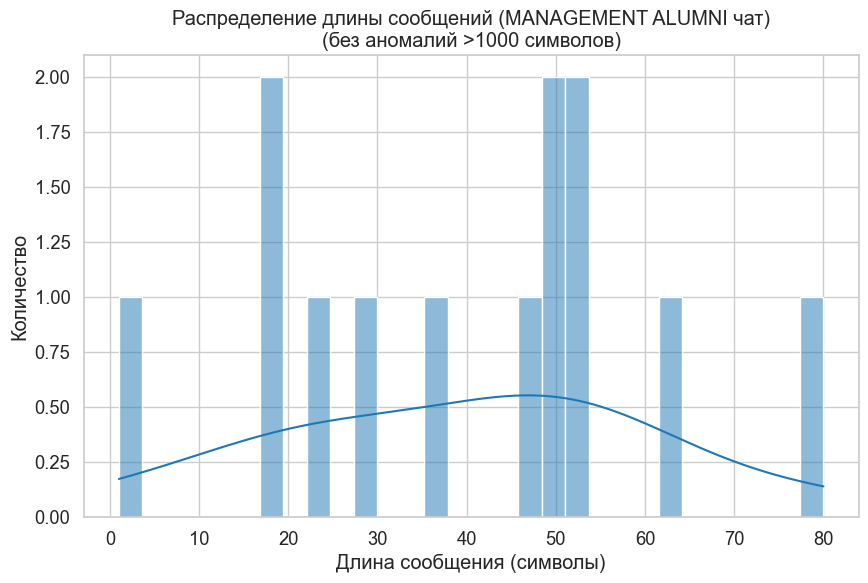

Медианная длина сообщения: 47.0 символов


<Figure size 1200x600 with 0 Axes>

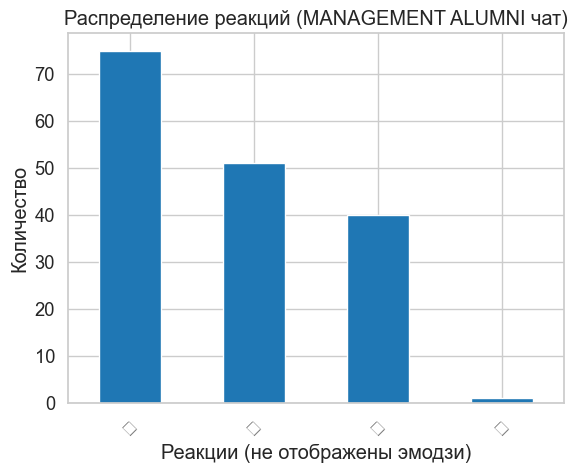


Дополнительный анализ (Data Practicum):


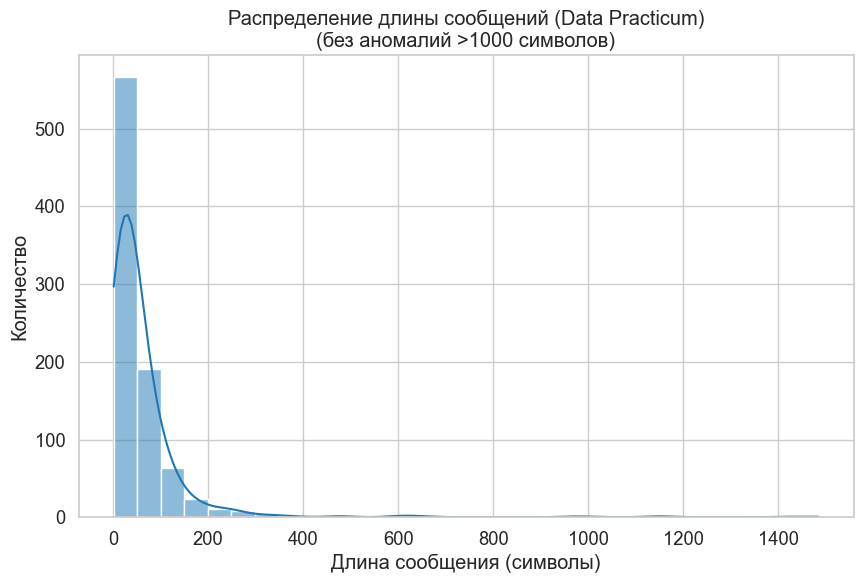

Медианная длина сообщения: 31.0 символов

Дополнительный анализ (marketing_chat чат):


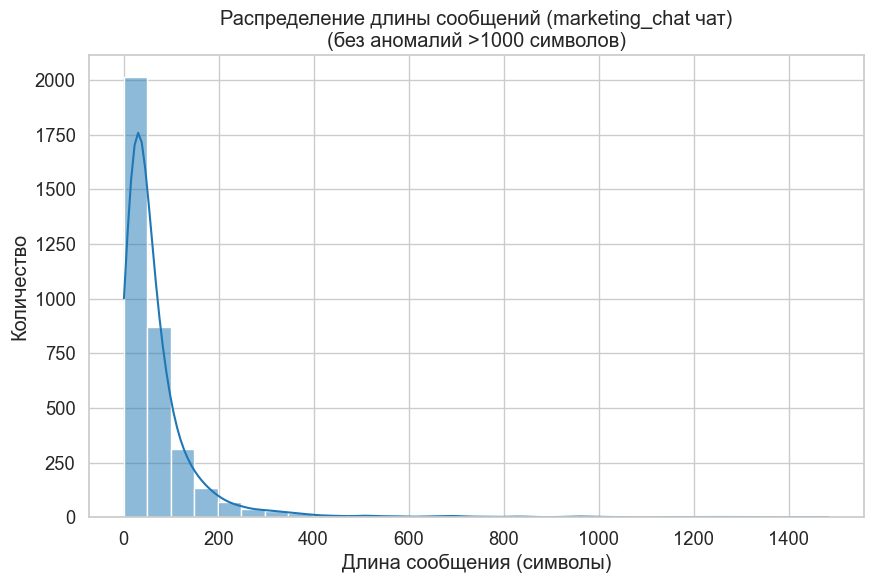

Медианная длина сообщения: 43.0 символов


In [35]:
def additional_analysis(df, dataset_name):
    """Дополнительные метрики с исправлениями"""
    print(f"\nДополнительный анализ ({dataset_name}):")
    
    # Длина сообщений (с фильтрацией аномалий)
    if 'text_clean' in df.columns:
        df['message_length'] = df['text_clean'].str.len()
        
        # Удаляем явные аномалии 
        lengths = df['message_length'].dropna()
        lengths = lengths[lengths < 1500]
        
        plt.figure(figsize=(10, 6))
        sns.histplot(lengths, bins=30, kde=True)
        plt.title(f'Распределение длины сообщений ({dataset_name})\n(без аномалий >1000 символов)')
        plt.xlabel('Длина сообщения (символы)')
        plt.ylabel('Количество')
        plt.show()
        
        print(f"Медианная длина сообщения: {lengths.median():.1f} символов")
    
    # Реакции 
    if 'reactions_clean' in df.columns:
        all_reactions = {}
        for reactions in df['reactions_clean'].dropna():
            if isinstance(reactions, dict):
                for emoji, count in reactions.items():
                    all_reactions[emoji] = all_reactions.get(emoji, 0) + count
        
        if all_reactions:
            reactions_df = pd.DataFrame(all_reactions.items(), columns=['emoji', 'count'])
            reactions_df = reactions_df.sort_values('count', ascending=False)
            
            # Создаем специальный шрифт для отображения эмодзи
            try:
                font_path = '..\def_Klyusnik_A\input\Symbola.ttf'  # Убедитесь, что файл шрифта доступен
                font_prop = fm.FontProperties(fname=font_path)
                
                plt.figure(figsize=(12, 6))
                bars = plt.bar(range(len(reactions_df)), reactions_df['count'], color='skyblue')
                
                # Добавляем подписи эмодзи
                for i, bar in enumerate(bars):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                            reactions_df.iloc[i]['emoji'],
                            ha='center', va='bottom',
                            fontproperties=font_prop, fontsize=12)
                
                plt.title(f'Распределение реакций ({dataset_name})')
                plt.xlabel('Реакции')
                plt.ylabel('Количество')
                plt.xticks([])  # Убираем стандартные подписи
                plt.show()
                
            except:
                # Если шрифт не загрузился, отображаем без эмодзи
                plt.figure(figsize=(12, 6))
                reactions_df.plot(kind='bar', x='emoji', y='count', legend=False)
                plt.title(f'Распределение реакций ({dataset_name})')
                plt.xlabel('Реакции (не отображены эмодзи)')
                plt.ylabel('Количество')
                plt.xticks(rotation=45)
                plt.show()

additional_analysis(manage_alumin, "MANAGEMENT ALUMNI чат")
additional_analysis(data_practicum, "Data Practicum")
additional_analysis(marketing_chat, 'marketing_chat чат')

## 7. ЭКСПОРТ РЕЗУЛЬТАТОВ

In [36]:

# def save_results(df, df_1):
#     """Сохранение результатов анализа"""
#     print("\nСохранение результатов...")
    
#     # Создаем Excel-файл с несколькими листами
#     with pd.ExcelWriter('chat_analysis_report.xlsx') as writer:
#         # Сводная статистика
#         summary_stats = pd.DataFrame({
#             'Метрика': [
#                 'Всего сообщений',
#                 'Уникальных пользователей', 
#                 'Средняя длина сообщения',
#                 'Пиковый час активности',
#                 'Самый активный день'
#             ],
#             'Менеджмент чат': [
#                 len(df),
#                 len(df['from'].unique()),
#                 f"{df['text_clean'].str.len().mean():.1f}",
#                 df['hour'].mode()[0],
#                 df['day_of_week'].mode()[0]
#             ],
#             'Групповой чат': [
#                 len(df_1),
#                 len(df_1['from'].unique()),
#                 f"{df_1['text_clean'].str.len().mean():.1f}",
#                 df_1['hour'].mode()[0],
#                 df_1['day_of_week'].mode()[0]
#             ]
#         })
#         summary_stats.to_excel(writer, sheet_name='Сводка', index=False)
        
#         # Топ пользователей
#         for name, data in [('Менеджмент', df), ('Групповой', df_1)]:
#             data['from'].value_counts().head(20).to_excel(
#                 writer, sheet_name=f'Топ пользователей {name}')
        
#         # Топ слов
#         for name, data in [('Менеджмент', df), ('Групповой', df_1)]:
#             if 'text_clean' in data.columns:
#                 clean_texts = data['text_clean'].dropna().astype(str)
#                 all_words = [word for text in clean_texts for word in text.split() if len(word) > 5]
#                 word_counts = Counter(all_words)
#                 pd.DataFrame(word_counts.items(), columns=['word', 'count'])\
#                     .sort_values('count', ascending=False)\
#                     .head(20)\
#                     .to_excel(writer, sheet_name=f'Топ слов {name}', index=False)
    
#     print("Результаты сохранены в chat_analysis_report.xlsx")

# save_results(df, df_1)